In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [5]:
def init_weights_Glorot(n_in, n_out):  # Glorot uniform
  w = np.zeros((n_in, n_out))
  #sd = 6.0 / np.sqrt(n_in + n_out)
  sd = np.sqrt(6.0 / (n_in + n_out))
  for i in range(n_in):
    for j in range(n_out):
      x = np.float32(np.random.uniform(-sd, sd))
      w[i,j] = x
  return w

In [6]:
class autoencoder:
    # __init__
    # d is the dimension of input vector 
    # n1 is the dimension of the hidden layer
    # MNIST classes = 10
    # ------------------------------------
    # The constructor should initialize the weights and biases for the two layers, W1, W2, b1,
    # and b2. Initialize the biases to zero, and sample the initial weights using the Glorot
    # initialization scheme
    # Also initialize here the quantities necessary to implement the Adam algorithm described
    # below: the timestep counter, and the storage for the gradient and curvature information
    # for the parameters W1, W2, b1, and b2
    def __init__(self, d, n1):
        self.d = d
        self.n1 = n1
        
        self.W1 = init_weights_Glorot(n1, d)
        self.b1 = np.zeros((n1, 1))
        self.W2 = init_weights_Glorot(d, n1)
        self.b2 = np.zeros((d, 1))
        
        # nuP and hP respectively contain gradient and curvature information that must be stored as instance attributes
        self.count = 0
        #self.param = [self.W1, self.b1, self.W2, self.b2]
        self.nuP = [np.zeros_like(self.W1), np.zeros_like(self.b1), np.zeros_like(self.W2), np.zeros_like(self.b2)]
        self.hP = [np.zeros_like(self.W1), np.zeros_like(self.b1), np.zeros_like(self.W2), np.zeros_like(self.b2)]

        
    
    # Activation functions
    # ------------------------------------
    # They should accept matrix arguments and respectively return the pointwise evaluation of 
    # the ReLu and logistic sigmoid activation functions
    def h1(self, a):
        return np.maximum(0, a)
    
    def h2(self, a):
        return 1/(1 + np.exp(-a)) 
    
    # Activation derivatives functions (not used right now)
    # ------------------------------------
    # They should accept matrices and return the pointwise evaluation of the derivatives of 
    # the corresponding activation functions
    # derivative of relu 
    def dh1(self, a):
        s = self.h1(a)
        return np.greater(s, 0).astype(int)
        
    # derivative of sigmoid
    def dh2(self, a):
        s = self.h2(a)
        return s*(1-s)
    
    # Loss derivative function
    # ------------------------------------
    # should assume that Ybatch was obtained by passing a minibatch through the autoencoder, 
    # and use the internal state of the autoencoder to compute the derivative of the loss above 
    # with respect to the output Ybatch
    def dloss(self, Yb, Xb):
        m = Yb.shape[0]
        dloss = - (1 / m) * ((np.divide(Xb, Yb, where=Yb != 0)) + (np.divide((1 - Xb), (1 - Yb), where=(1 - Yb) != 0)))
        return dloss
    
    # Loss function 
    # ------------------------------------
    # computes the average binary cross-entropy reconstruction loss when the autoencoding of 
    # Xbatch is used to approximate Xbatch,
    def loss(self, Xb):
        ##print("-- loss --")
        #print("Ybatch: ", Ybatch)
        '''
        print("Yb(a2): ")
        print(Yb)
        print("Yb zero test: ")
        print(np.all(Yb))
        print(np.all(1 - Yb))
        '''
        Yb, cache = self.forward(Xb)
        m = Yb.shape[0]
        
        loss = - (1/m) * np.sum(Xb * np.ma.log(Yb) - (1 - Xb) * np.ma.log(1 - Yb))
        loss = np.squeeze(loss)
        
        #print("loss: ", loss)
        
        #print("dloss: ", dloss)
        
        return loss
    
    # forward function
    # ------------------------------------
    # Xbatch is a d x m matrix whose columns comprise a minibatch 
    # To facilitate their use in backpropagation, this function should store Xbatch and the
    # activations a1 and a2 and outputs o1 and o2 as instance attributes.
    def forward(self, Xbatch):
        ##print("-- forward --")
        #print("Xbatch[0]: ")
        #print(Xbatch[0])
        o1 = self.W1 @ Xbatch + self.b1
        #print("o1: ")
        #print(o1)
        a1 = self.h1(o1)
        #print("a1: ")
        #print(a1)
        o2 = self.W2 @ a1 + self.b2
        #print("o2: ")
        #print(o2)
        a2 = self.h2(o2)
        #print("a2: ")
        #print(a2)
        
        #print("o1 | a1 | o2 | a2")
        #print(o1.shape, a1.shape, o2.shape, a2.shape)
        

        cache = {
            "o1": o1,
            "a1": a1,
            "o2": o2,
            "a2": a2,
            "Xbatch": Xbatch
        }
        
        return a2, cache
    
    # backward function (not sure if do2/do1 is correct)
    # ------------------------------------
    # This function should compute and store attributes dW1, dW2, db1, db2 containing 
    # the gradients of the training objective with respect to the parameters of the autoencoder, 
    # using the values stored from an earlier call to forward.
    def backward(self, cache):
        ##print("-- backward --")
        o1 = cache["o1"]
        o2 = cache["o2"]
        a1 = cache["a1"]
        a2 = cache["a2"]
        Xb = cache["Xbatch"]
        m = a2.shape[0]
        ##print("a2: ", a2.shape)
        # this stores the sum of gradient in the minibatch for W1 | b1 | W2 | b2
        gradient = [np.zeros_like(self.W1), np.zeros_like(self.b1), np.zeros_like(self.W2), np.zeros_like(self.b2)]
        for i in range(m):
            #print("a2_i: ", a2[i].shape)
            do2_i = self.dh2(a2[i])
            #print("do2_i: ", do2_i.shape)
            gradient[2] += do2_i @ a1[i].T
            #print("dw2_i: ", dw2_i.shape)
            gradient[3] += np.sum(do2_i, axis = 1, keepdims = True)
            #print("db2_i: ", db2_i.shape)
            do1_i = self.dh1(a1[i])
            #print("do1_i: ", do1_i.shape)
            gradient[0] += np.dot(do1_i, Xbatch[i].T)
            #print("dw1_i: ", dw1_i.shape)
            gradient[1] += np.sum(do1_i, axis = 1, keepdims = True)
            #print("db1_i: ", db1_i.shape)
        gradient[0] = gradient[0] * (1 / m)
        gradient[1] = gradient[1] * (1 / m)
        gradient[2] = gradient[2] * (1 / m)
        gradient[3] = gradient[3] * (1 / m)
        
        self.adam_step(gradient, 0.001, 0.9, 0.999, 1e-8)
        '''
        do2 = self.dh2(a2)
        print("do2: ", do2.shape)
        print("a1.T: ", a1.T.shape)
        #dw2 = (1 / m) * np.dot(do2, a1.T)
        dw2 = (1 / m) * (do2 @ a1.T)
        db2 = (1 / m) * np.sum(do2, axis = 1, keepdims = True)
        
        do1 = self.dh1(a1)
        print("do1: ", do1.shape)
        dw1 = (1 / m) * np.dot(do1, Xbatch.T)
        db1 = (1 / m) * np.sum(do1, axis = 1, keepdims = True)
        gradient = [dw1, db1, dw2, db2]
        print("dw1 | db1 | dw2 | db2")
        print(dw1.shape, db1.shape, dw2.shape, db2.shape)
        print(dw1, db1, dw2, db2)
        '''
        
        '''
        print("Ybatch(a2): ", a2.shape)
        print("Xbatch: ", Xb.shape)
        loss, dloss = self.loss(a2, Xb)
        print("loss | dloss")
        print(loss.shape, "|", dloss.shape)
        '''
        
        
        # should call Adam optimizer here to update parameters
        
        
        #return dw1, db1, dw2, db2
        
    # Adam optimizer function
    # ------------------------------------
    # that implements a single step of the Adam optimization algorithm to up-
    # date the autoencoder's parameters. This function assumes that forward then backward
    # were called immediately before it to generate the quantities needed in the optimization
    # process.
    def adam_step(self, gradient, alpha=0.001, rho1=0.9, rho2=0.999, delta=1e-8):
        self.count += 1
        ##print("-- adam_step --")

        for i in range(4):
            self.nuP[i] = rho1 * self.nuP[i] + (1 - rho1) * gradient[i]
            #print("nuP: ", self.nuP.shape)
            self.hP[i] = rho2 * self.hP[i] + (1 - rho2) * np.multiply(gradient[i], gradient[i])
            #print("hP: ", self.hP.shape)
            nuPhat = self.nuP[i] / (1 - (rho1**self.count))
            hPhat = self.hP[i] / (1 - (rho2**self.count))
            if (i == 0):
                self.W1 = self.W1 - np.divide((alpha * nuPhat), (np.sqrt(hPhat) + delta))
            elif (i == 1):
                self.b1 = self.b1 - np.divide((alpha * nuPhat), (np.sqrt(hPhat) + delta))
            elif (i == 2):
                self.W2 = self.W2 - np.divide((alpha * nuPhat), (np.sqrt(hPhat) + delta))
            elif (i == 3):
                self.b2 = self.b2 - np.divide((alpha * nuPhat), (np.sqrt(hPhat) + delta))
            #self.param[i] = self.param[i] - (alpha * nuPhat)/(math.sqrt(hPhat) + delta)
            #tmp = (alpha * nuPhat)/(math.sqrt(hPhat) + delta)

        
        
        

In [7]:
# ------------------------------------
# Load MNIST from keras
# ------------------------------------
from keras.datasets import mnist
import matplotlib.pyplot as plt

(Xtrain, Ytrain), (Xtest, Ytest) = mnist.load_data()

print(Xtrain.shape, Xtrain[0].shape)
print(Ytrain.shape, Ytrain[0].shape)

plt.subplot(221)
plt.imshow(Xtrain[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(Xtrain[1], cmap=plt.get_cmap('gray'))
plt.show()



ModuleNotFoundError: No module named 'keras'

In [95]:
# simple usage (no-minibatch version for testing)
d = 28
n1 = 100
ntrain = Xtrain.shape[0]
numepochs = 10
numsplits = 60

ae = autoencoder(d, n1)

#print("-- main --")

'''
print("W1: ")
print(ae.W1)
print("b1: ")
print(ae.b1)
print("W2: ")
print(ae.W2)
print("b2: ")
print(ae.b2)
'''

for i in range(numepochs):
    print("Training loss [%d/%d]: %.2f" % (i+1, numepochs, ae.loss(Xtrain)))
    minibatches = np.split(np.random.permutation(ntrain), numsplits)
    
    for indices in minibatches:
        
        # Xbatch is [m x d x d]
        # Ybatch is [m]
        Xbatch = Xtrain[indices]
        a2, cache = ae.forward(Xbatch)
        ae.backward(cache)
    
    #print("minibatches: ", minibatches[0])
    
    '''
    print("Xbatch: ")
    print(Xbatch.shape)
    print(Xbatch)
    
    print("Xbatch[0]: ")
    print(Xbatch[0].shape)
    print(Xbatch[0])
    '''


    '''
    for y in range(10):
        plt.subplot(1, 10, y+1)
        plt.imshow(Xbatch[y], cmap=plt.get_cmap('gray'))
    plt.show()
    '''
    

Training loss [1/10]: 910498.93
Training loss [2/10]: 441327.51
Training loss [3/10]: 107322.47
Training loss [4/10]: 50156.22
Training loss [5/10]: 32520.30
Training loss [6/10]: 25743.71
Training loss [7/10]: 23016.83
Training loss [8/10]: 22083.31
Training loss [9/10]: 22045.29
Training loss [10/10]: 22511.07


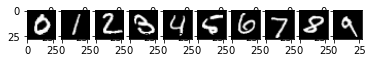

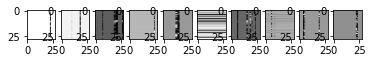

In [109]:
# ------------------------------------
# Plot for test
# ------------------------------------
test_index = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
test_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
count = 0
for i in range(len(Ytest)):
    #print(Ytest[i])
    if count == 10:
        break
    if test_index[int(Ytest[i])] == -1:
        test_list[int(Ytest[i])] = Xtest[i]
        #print(Ytest[i], Xtest[i])
        test_index[int(Ytest[i])] = 0
        count += 1

predict_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# start prediction
for i in range(len(test_list)):
    predict_list[i] = ae.forward(test_list[i])[0]
    assert predict_list[i].shape == test_list[i].shape

for i in range(len(test_list)):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_list[i], cmap=plt.get_cmap('gray'))
plt.show()

for i in range(len(predict_list)):
    plt.subplot(1, 10, i+1)
    plt.imshow(predict_list[i], cmap=plt.get_cmap('gray'))
plt.show()
